<a href="https://colab.research.google.com/github/ujanichakma/AI_LAB_4-1_2025/blob/main/AI_final_assignment/AI_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.7558 - loss: 0.7679
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9827 - loss: 0.0720
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9962 - loss: 0.0258


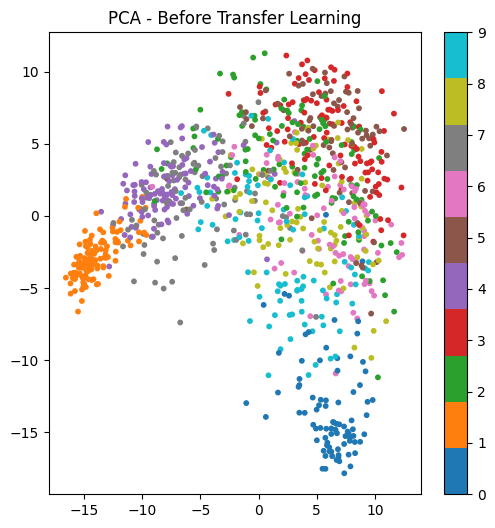

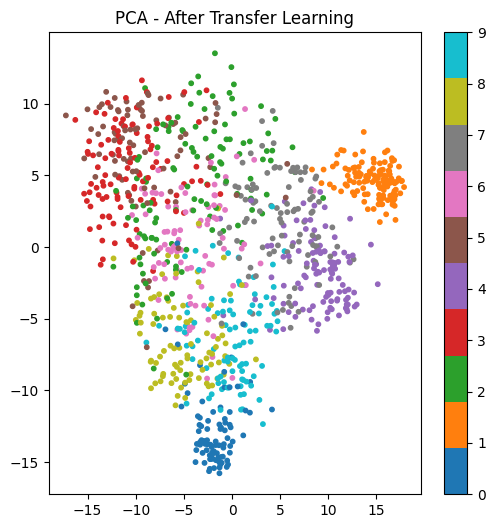

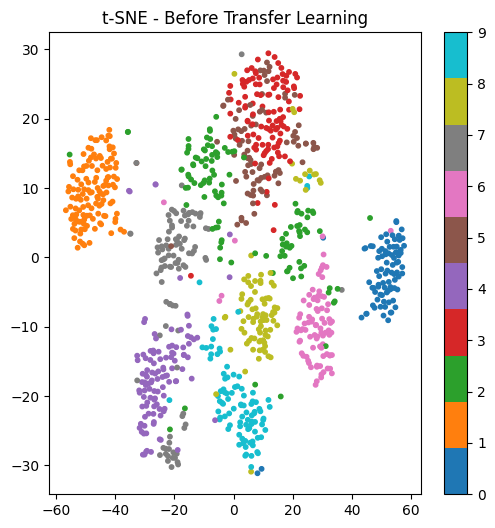

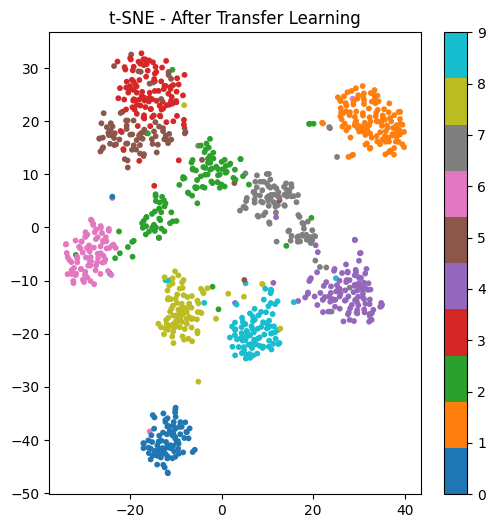

In [1]:
# ================= IMPORT =================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("GPU:", tf.config.list_physical_devices('GPU'))

# ================= LOAD MNIST =================
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Use small subset for speed
x_train = x_train[:5000]
y_train = y_train[:5000]
x_test  = x_test[:1000]
y_test  = y_test[:1000]

# reshape & resize
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

x_train = tf.image.resize(x_train, (96,96))
x_test  = tf.image.resize(x_test, (96,96))

# grayscale → RGB
x_train = tf.image.grayscale_to_rgb(x_train)/255.0
x_test  = tf.image.grayscale_to_rgb(x_test)/255.0

# ================= BASE MODEL =================
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(96,96,3))

feature_layer = GlobalAveragePooling2D()(base_model.output)
classifier = Dense(10, activation='softmax')(feature_layer)

model = Model(base_model.input, classifier)

# ================= FEATURE EXTRACTOR =================
feature_extractor = Model(base_model.input, feature_layer)

# -------- BEFORE TRANSFER LEARNING --------
features_before = feature_extractor.predict(x_test, verbose=0)

# ================= TRANSFER LEARNING =================
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3, batch_size=32, verbose=1)

# -------- AFTER TRANSFER LEARNING --------
features_after = feature_extractor.predict(x_test, verbose=0)

# ================= PCA FUNCTION =================
def plot_pca(features, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(features)
    plt.figure(figsize=(6,6))
    plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()

# ================= TSNE FUNCTION =================
def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, perplexity=30)
    reduced = tsne.fit_transform(features)
    plt.figure(figsize=(6,6))
    plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=10)
    plt.title(title)
    plt.colorbar()
    plt.show()

# ================= PLOTS =================
plot_pca(features_before, y_test, "PCA - Before Transfer Learning")
plot_pca(features_after,  y_test, "PCA - After Transfer Learning")

plot_tsne(features_before, y_test, "t-SNE - Before Transfer Learning")
plot_tsne(features_after,  y_test, "t-SNE - After Transfer Learning")